# **Tổng quan về Gradient Boosting**

Gradient Boosting là một trong những thuật toán máy học phổ biến và hiệu quả để tìm mối quan hệ không tuyến tính giữa biến mục tiêu và các biến đầu vào. \
Ensemble Learning là phương pháp kết hợp nhiều mô hình học máy đơn giản, có độ chính xác thấp để tạo ra một mô hình mạnh mẽ hơn. Ensemble Learning có thể chia thành 3 loại sau:
* Bagging: Random Forest
* Boosting: Gradient Boosting, AdaBoost, XGBoost, LightGBM, CatBoost
* Stacking 
  
*Tham khảo*: [Tóm tắt về Ensemble Learning](https://qiita.com/ngomanh/items/fc6eb34986068e2bb6e4)

# **Cách hoạt động của Gradient Boosting**

<div style="text-align: center;">
    <img src = "image.png" width = "700"/>
</div>

## **Mô tả dưới dạng toán học**

### **Loss function**

Trong Gradient Boosting, tùy thuộc vào mục đích của bài toán, chúng ta sẽ chọn một hàm mất mát phù hợp. Ví dụ, nếu chúng ta đang làm việc với bài toán hồi quy, chúng ta có thể chọn hàm mất mát là Mean Squared Error (MSE). Nếu chúng ta đang làm việc với bài toán phân loại, chúng ta có thể chọn hàm mất mát là Cross-Entropy. \
Vì bài toán dự đoán giá nhà là bài toán hồi quy, chúng ta sẽ chọn hàm mất mát là MSE.\

Tham khảo: [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

## **Thuật toán**

*THam khảo*: [All You Need to Know about Gradient Boosting Algorithm − Part 1. Regression](https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502)

#### **Khởi tạo mô hình bằng một hằng số:**
$$
F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma)
$$

#### **Với mỗi lần lặp t từ 1 đến M:**


##### **Tính giá trị thặng dư**
Với mỗi điểm dữ liệu i, chúng ta tính giá trị thặng dư, giống như trong Gradient Descent:
$$
r_{im} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)}
$$

Đạo hàm ta được:

$$
\begin{align}
r_{im} & = - \frac{\partial (y_i - F_{m-1})^2}{\partial F_{m-1}} &\newline
& = 2(y_i - F_{m-1}) &
\end{align}
$$

Vậy: $$r_{im} = y_i - F_{m-1}$$

#####  **Xây dựng Decision Tree**

Dùng các giá trị thặng dự $r_{im}$ làm biến mục tiêu để xây dựng Decision Tree. Quá trình này tạo ra $R_{jm}$ là một tập hợp các lá của Decision Tree với j = 1...$J_m$

*Minh họa decision tree:*

8.11582727894544


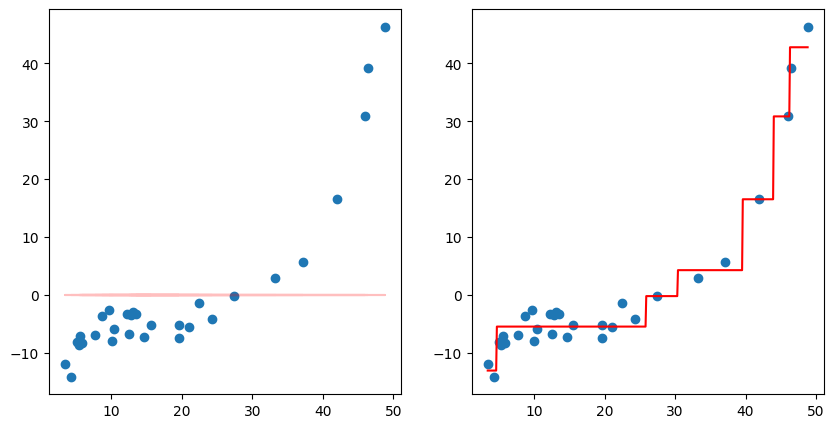

In [1]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

# ham tao du lieu gia lap
def generate_nonlinear_data(n_points):
    x = np.random.rand(n_points) * 50
    y = 0.002 * (x - 20) ** 3 + 5 + np.random.randn(n_points) * 2.5
    return x, y

# Tạo dữ liệu giả lập
x, y = generate_nonlinear_data(30)
df = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows= 1)
print(y.mean())
residuals = y - y.mean()

ax[0].scatter(x, residuals)
ax[0].plot(x, np.zeros_like(x), color='red', alpha = 0.25)


# Dung desicion tree de du doan residuals theo x
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(x.reshape(len(x), 1), residuals)

# Ve du doan cua decision tree
X_grid = np.arange(x.min(), x.max(), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))

ax[1].scatter(x, residuals)
ax[1].plot(X_grid, tree.predict(X_grid), color='red')



#### **Tìm giá trị tối ưu cho các nút lá của cây:**
$$\begin{align}
    \gamma_{jm} & = \argmin_{\gamma} \sum_{X \in \mathcal{R}_{jm}}^{L} L(y_i, F_{m-1}(x_i) + \gamma)  \quad \text{for} \quad j = 1, \ldots, J_m & \\
    & = \arg \min_{\gamma} \sum_{x_i \in R_{jm}} (y_i - F_{m-1}(x_i) - \gamma)^2 &
\end{align}
$$


Cho đạo hàm của tổng theo $\gamma$ bằng 0, ta có:



$$\begin{align}
\frac{\partial}{\partial \gamma} \sum_{x_i \in R_jm} (y_i - F_{m-1}(x_i) - \gamma)^2 &= 0 & \\
-2 \sum_{x_i \in R_jm} (y_i - F_{m-1}(x_i) - \gamma) & = 0 & \\
n_m\gamma & = \sum_{x_i \in R_jm} (y_i - F_{m-1}(x_i)) & \\
\gamma & = \frac{1}{n_m} \sum_{x_i \in R_jm} r_{im} \\
\end{align}
$$



Vậy giá trị $\gamma_{jm}$ tối ưu cho nút lá j là trung bình cộng của các giá trị thặng dư tương ứng với các điểm dữ liệu rơi vào nút lá đó.\
Do đó, giá trị $\gamma_{jm}$ cũng là giá trị dự đoán của Decision Tree tại nút lá j.

#### **Cập nhật mô hình:**

$$
F_m(x) = F_{m-1}(x) + \nu \sum_{j=1}^{J_m} \gamma_{jm} I(x \in R_{jm})
$$

Với $\nu$ là learning rate, nằm trong khoảng 0 và 1, thể hiện mức độ đóng góp của Decision Tree thứ m vào mô hình cuối cùng.

## **Thử implement trên dữ liệu 2 chiều**

### **Tạo dữ liệu mô phỏng**

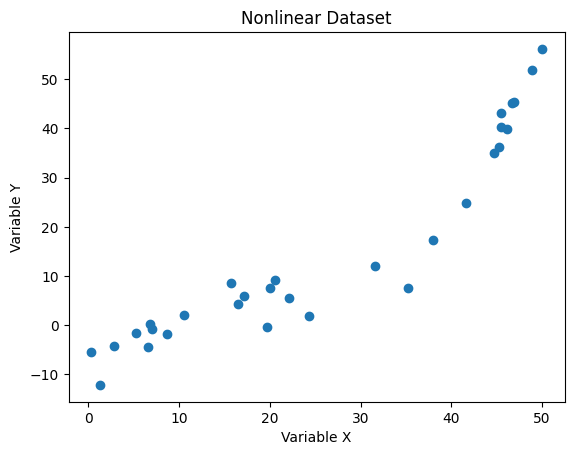

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Tao du lieu gia lap
x, y = generate_nonlinear_data(30)
df = pd.DataFrame({'x': x, 'y': y})

plt.scatter(x, y)
plt.xlabel('Variable X')
plt.ylabel('Variable Y')
plt.title('Nonlinear Dataset')
plt.show()


### **Xậy dựng hàm fit()  và predict() đơn giản**

In [3]:
from sklearn.tree import DecisionTreeRegressor
class SimpleGradientBoosting:
    def __init__(self, number_of_estimators=15, learning_rate=0.1, max_depth=5):
        self.number_of_estimators = number_of_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, x, y):
        # Bat dau voi hang so khoi tao
        F0 = y.mean()

        Fm = F0

        for i in range(self.number_of_estimators):
            # Tinh gia trị thặng dư
            residuals = y - Fm

            # Sử dụng cây quyết định để dự đoán residuals theo x
            tree = DecisionTreeRegressor(max_depth=self.max_depth)

            # Giá trị tối ưu của gamma cho nút là giá trị trung bình của residuals
            # Cũng là giá trị cây quyết định dự đoán
            tree.fit(x.reshape(-1, 1), residuals)
            gamma = tree.predict(x.reshape(-1, 1))

            # Cập nhật Fm
            Fm += self.learning_rate * gamma

            # Thêm cây vào danh sách
            self.trees.append(tree)

    def predict(self, X):
        F0 = y.mean()
        Fm = F0
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        return Fm
        



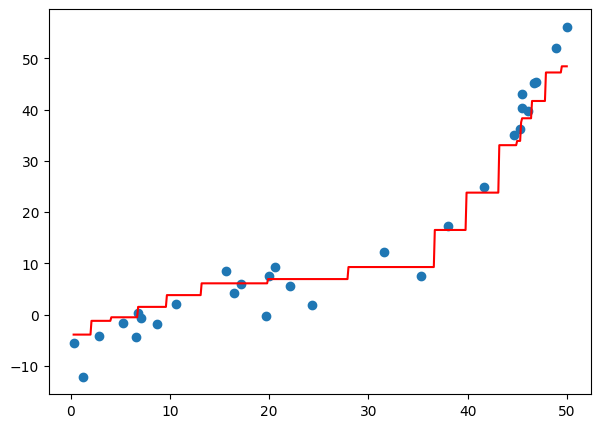

In [4]:
simpleGradientBoosting = SimpleGradientBoosting(number_of_estimators=20, learning_rate=0.1, max_depth=2)
simpleGradientBoosting.fit(x, y)

# Lay mien du lieu cua x de ve
X_grid = np.arange(x.min(), x.max(), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y)
ax.plot(X_grid, simpleGradientBoosting.predict(X_grid), color='red')

# **Áp dụng vào bài toán dự đoán giá nhà**

In [5]:
!pip install -U scikit-learn

In [6]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/KhiemDangLe/Final-Project/main/DataFolder/5_preprocessed_data.csv", header=0)

## **Tiền xử lý dữ liệu**

Vì phần sau sẽ có so sánh giữa các mô hình khác nhau, nên chúng ta sẽ sử dụng ColumnTransformer, Pipeline để áp dụng các cách thức tiền xử lý dữ liệu khác nhau cho từng mô hình.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   article_id          5595 non-null   int64  
 1   category            5595 non-null   object 
 2   phone               5594 non-null   float64
 3   district            5595 non-null   object 
 4   date_posted         5595 non-null   object 
 5   area                5580 non-null   float64
 6   bedroom             4954 non-null   float64
 7   wc                  4537 non-null   float64
 8   direction           566 non-null    object 
 9   balcony_direction   234 non-null    object 
 10  total_room_LLm      2863 non-null   float64
 11  count_conveniences  5595 non-null   int64  
 12  alleyway_property   4866 non-null   float64
 13  under_mortgage      979 non-null    float64
 14  furnished           1426 non-null   float64
 15  has_lowerlevel      1415 non-null   float64
 16  has_ro

### **Phân loại các cột**

Các cột sẽ được phân loại thành 3 nhóm:
- str_cat_columns: Các cột dạng categorical, ở dạng chuỗi
- int_cat_columns: Các cột dạng categorical, ở dạng số
- numerical_columns: Các cột dạng số

In [8]:
str_cat_columns = ['category', 'district', 'direction', 'balcony_direction']
int_cat_columns = ['bedroom', 'wc', 'total_room_LLm', 'count_conveniences', 'numbers_of_floors', 'alleyway_property', 'under_mortgage', 'furnished', 'has_lowerlevel', 'has_rooftop']
numerical_columns = ['area']

y = data['price'].copy()
X = data[str_cat_columns + int_cat_columns + numerical_columns].copy()
X[str_cat_columns + int_cat_columns] = X[str_cat_columns + int_cat_columns].astype('category')

print("Số dòng X: ", X.shape[0])
print("Số cột X: ", X.shape[1])
print("Số dòng y: ", y.shape[0])

Số dòng X:  5595
Số cột X:  15
Số dòng y:  5595


### **Xử lý cột area**

In [9]:
print("Tỷ lệ dữ liệu ở cột area bị thiếu:", X['area'].isnull().sum()/X.shape[0] * 100, "%")

Tỷ lệ dữ liệu ở cột area bị thiếu: 0.2680965147453083 %


Dữ liệu bị thiếu ở cột area là rất thấp, chúng ta có thể xóa các dòng dữ liệu này. Tuy nhiên, vì phần sau sẽ sử dụng pipeline khác nhau cho từng mô hình, nên chúng ta sẽ điền giá trị thiếu bằng giá trị trung bình của cột area.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

area_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

### **Xử lý biến phân loại**

In [11]:
X[str_cat_columns + int_cat_columns].isnull().sum()

category                 0
district                 0
direction             5029
balcony_direction     5361
bedroom                641
wc                    1058
total_room_LLm        2732
count_conveniences       0
numbers_of_floors      370
alleyway_property      729
under_mortgage        4616
furnished             4169
has_lowerlevel        4180
has_rooftop           3625
dtype: int64

Các cột biến phân loại có những cột có nhiều giá trị thiếu. Chúng ta sẽ xem giá trị thiếu ở các cột này là một giá trị mới. Tùy thuộc vào cột đó là cột dạng số hay chuỗi, giá trị "Other" hoặc -1.0 sẽ được thêm vào.

In [12]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

str_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = "Other")),
    # Khi chia dữ liệu thành tập huấn luyện và tập kiểm tra, có thể có các giá trị không xuất hiện trong tập huấn luyện nhưng xuất hiện trong tập kiểm tra
    # Để xử lý trường hợp này, sử dụng tham số handle_unknown='use_encoded_value' và unknown_value=-1
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

int_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value = -1.0)),
    ('encoder', OrdinalEncoder())
])

### **Tạo pipeline**

Chúng ta có các pipleline sau:
- **preprocessed_gd_pipeline**: Điền giá trị thiếu và encoding cho các biến phân loại bằng class CustomImputer và CustomEncoder. Sau đó, sử dụng mô hình GradientBoostingRegressor để dự đoán giá nhà.
- **hist_native_pipeline**: Không xử lý dữ liệu bị thiếu, không encoding các biến phân loại. Sử dụng mô hình HistGradientBoostingRegressor với các thông số mặc định với khả năng tự xử lý dữ liệu thiếu và encoding biến phân loại. Sau đó sử dụng hist_native_pipeline để so sánh với preprocessing_gd_pipeline.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer

# preprocessed_gd_pipeline
col_trans = ColumnTransformer(transformers=[
    ('area_pipeline',area_pipeline, numerical_columns),
    ('str_cat_pipeline',str_cat_pipeline, str_cat_columns),
    ('int_cat_pipeline', int_cat_pipeline, int_cat_columns)
    ],
    remainder='drop',
    n_jobs=-1)

preprocessed_gd_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', GradientBoostingRegressor())
])

# hist_native_pipeline
hist_native_pipeline = HistGradientBoostingRegressor(
    loss = 'squared_error',
    random_state=42, categorical_features="from_dtype",
    early_stopping=False
)


## **So sánh giữa mô hình GradientBoostingRegressor và HistGradientBoostingRegressor**

Vì thư viện sklearn có thư viện HisGradientBoostingRegressor, có hỗ trợ xử lý dữ liệu bị thiếu, nên ta sẽ sử dụng thư viện này để xây dựng mô hình dự đoán giá nhà. HisGradientBoostingRegressor là bản cải tiến của GradientBoostingRegressor, có tốc độ chạy nhanh hơn và sử dụng ít bộ nhớ hơn so với GradientBoostingRegressor nhờ sử dụng kiến trúc dạng histogram.

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score

def compare_models_with_CV(model1, model2, X, y, cv = 5):
    metrics = ('neg_mean_squared_error', 'r2')
    # reshape X and y
    scores1 = cross_validate(model1, X, y, cv = 4, scoring = metrics)
    scores2 = cross_validate(model2, X, y, cv = 4, scoring = metrics)

    return scores1, scores2

scores1, scores2 = compare_models_with_CV(preprocessed_gd_pipeline, hist_native_pipeline, X, y)


In [15]:
from tabulate import tabulate

mean_fit_time1 = scores1['fit_time'].mean()
mean_r2_score1 = scores1['test_r2'].mean()
mean_mse1 = -scores1['test_neg_mean_squared_error'].mean()

mean_fit_time2 = scores2['fit_time'].mean()
mean_r2_score2 = scores2['test_r2'].mean()
mean_mse2 = -scores2['test_neg_mean_squared_error'].mean()

print(tabulate([['GradientBoostingRegressor', mean_fit_time1, mean_r2_score1, mean_mse1], ['HistGradientBoostingRegressor', mean_fit_time2, mean_r2_score2, mean_mse2]], headers=['Model', 'Mean fit time', 'Mean R2 score', 'Mean MSE'], tablefmt='orgtbl'))

| Model                         |   Mean fit time |   Mean R2 score |   Mean MSE |
|-------------------------------+-----------------+-----------------+------------|
| GradientBoostingRegressor     |        1.08828  |        0.512082 |    2.0257  |
| HistGradientBoostingRegressor |        0.309438 |        0.528383 |    1.94481 |


Về mặt kết quả:
- HisGradientBoostingRegressor có thời gian chạy nhanh hơn GradientBoostingRegressor. Ngoài ra, khi dữ liệu lớn hơn 10000 dòng, HistGradientBoostingRegressor sẽ chạy nhanh hơn rất nhiều so với GradientBoostingRegressor.
- HisGradientBoostingRegressor có kết quả tốt hơn so với GradientBoostingRegressor ở chỉ số R2 và RMSE. Điều này cho thấy HisGradientBoostingRegressor có khả năng tự xử lý dữ liệu bị thiếu và encoding biến phân loại tốt hơn so với GradientBoostingRegressor.
Do đó, ở phần sau, chúng ta sẽ sử dụng HisGradientBoostingRegressor và tối ưu hóa mô hình này.

Ta sẽ sử dụng tham số R2 là 0.528383 và RMSE là 0.1912 đề làm mục tiêu tối ưu hóa mô hình.

## **Feature Importance**

Chúng ta sẽ sử dụng Permutation Importance để xem xét mức độ quan trọng của các biến đầu vào đối với mô hình dự đoán giá nhà. Ưu điểm của Permuatation Importances so với phương pháp đánh giá dựa trên độ nhiễu (impurity-based) là:
- Có thể đánh giá dưạ trên dữ liệu chưa thấy nhờ ngẫu nhiên hoán vị thứ tự của các biến đầu vào.
- Tránh vấn đề bị thiên lệch đối với biến có nhiều giá trị như biến số hơn các biến có ít giá trị như biến phân loại. 

Tham khảo: [Relation to impurity-based importance in trees](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees)

In [11]:
from sklearn.inspection import permutation_importance
hist_native_pipeline.fit(X, y)
result = permutation_importance(hist_native_pipeline, X, y, n_repeats=10, random_state=42, n_jobs=-1)

In [12]:
result_Series = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
result_Series

area                  0.535664
district              0.483457
bedroom               0.087575
wc                    0.087039
numbers_of_floors     0.068808
count_conveniences    0.044671
has_rooftop           0.030248
total_room_LLm        0.023741
furnished             0.015670
direction             0.013580
under_mortgage        0.011412
alleyway_property     0.009097
has_lowerlevel        0.008106
balcony_direction     0.003291
category              0.002676
dtype: float64

**Loại bỏ các cột có ảnh hưởng thấp**

In [13]:
new_str_cat_columns = ['district', 'direction']
new_int_cat_columns = ['bedroom', 'wc', 'total_room_LLm', 'count_conveniences', 'numbers_of_floors', 'furnished', 'has_rooftop']

**Chạy lại mô hình**

In [14]:
from sklearn.model_selection import cross_validate
metrics = ['neg_mean_squared_error', 'r2']
scores = cross_validate(hist_native_pipeline, X[new_str_cat_columns + new_int_cat_columns + numerical_columns], y, cv = 5, scoring = metrics)

In [15]:
print("Trung bình MSE: ",scores['test_neg_mean_squared_error'].mean())
print("Trung bình R2:", scores['test_r2'].mean())

Trung bình MSE:  -1.83127061539362
Trung bình R2: 0.5534821125805982


**Cập nhật lại X**

In [16]:
X = X[new_str_cat_columns + new_int_cat_columns + numerical_columns].copy()

## **Tinh chỉnh siêu tham số (Hyperparameter Tunning) cho mô hình HistGradientBoostingRegressor**

### **Các thông số của mô hình HistGradientBoostingRegressor**

Các thông số của mô hình HistGradientBoostingRegressor:
```python
class sklearn.ensemble.HistGradientBoostingRegressor(loss='squared_error', *, quantile=None, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_features=1.0, max_bins=255, categorical_features='warn', monotonic_cst=None, interaction_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
```

Các thông số của mô hình có thể chia thành 3 loại:
- **Thống số ảnh hưởng đến cấu trúc cây**: min_samples_leaf, max_depth, max_leaf_nodes, max_features. Những thông số này sẽ ảnh hưởng đến cấu trúc của cây trong thuật toán.
- **Thống số ảnh hưởng đến việc cập nhật mô hình**: learning_rate, max_iter,
- **Các thông số khác**: loss, l2_regularization, max_bins, warm_start, early_stopping, ,..

### **Hướng tiếp cận**

Tham khảo: [Link](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

- Thông thường chọn learning_rate nằm trong khoảng 0.05 đến 0.2
- Chọn xố lượng cây tối ưu cho learning_rate đã chọn.
- Tối ưu các thông số ảnh hưởng đến cấu trúc cây
- Giảm learning_rate và tăng các thông số để tăng độ chính xác của mô hình.

### **Chọn learning_rate**

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]}
gsearch = GridSearchCV(estimator = hist_native_pipeline, param_grid = param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gsearch.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15, 0.175,
                                           0.2]},
             scoring='neg_mean_squared_error')

In [18]:
gsearch.cv_results_['mean_test_score']

array([-1.83700666, -1.83069523, -1.83127062, -1.85694035, -1.88382226,
       -1.93127208, -1.90667431])

In [19]:
gsearch.best_params_

{'learning_rate': 0.075}

In [20]:
hist_native_pipeline.learning_rate = gsearch.best_params_['learning_rate']

### **Xác định số lần lặp tối ưu cho mô hình với learning_rate đã xác định**

Trong bước này, chúng ta sẽ chọn số lần lặp tối ưu cho mô hình với learning_rate đã xác định thông qua tham só max_iter. Tuy nhiên,

**Số lần lặp trong khoảng 100 đến 500**

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': range(100, 400, 50)}
gsearch2 = GridSearchCV(estimator = hist_native_pipeline, param_grid = param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gsearch2.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     learning_rate=0.075,
                                                     random_state=42),
             n_jobs=-1, param_grid={'max_iter': range(100, 400, 50)},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'Root Mean Squared Error')

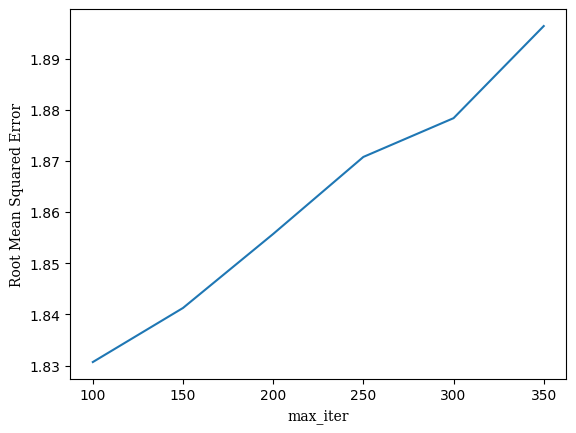

In [22]:
import matplotlib.pyplot as plt
# Plot the results of the grid search for the max_iter parameter vs the MSE
plt.plot(gsearch2.cv_results_['param_max_iter'], - gsearch2.cv_results_['mean_test_score'])
plt.xlabel('max_iter', fontfamily='serif')
plt.ylabel('Root Mean Squared Error', fontfamily='serif')

Ta thấy rằng với độ chính xác của mô hình lại giảm đi khi số lần lặp tăng lên. Điều này cho thấy mô hình bị overfitting. Vì vậy ta sẽ kiểm tra số lần lặp nhỏ hơn.

**Số lần lặp trong khoảng 10 đến 100**

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': range(10, 150, 5)}
gsearch2 = GridSearchCV(estimator = hist_native_pipeline, param_grid = param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
gsearch2.fit(X, y)



GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     learning_rate=0.075,
                                                     max_iter=80,
                                                     random_state=42),
             n_jobs=-1, param_grid={'max_iter': range(10, 150, 5)},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'Root Mean Squared Error')

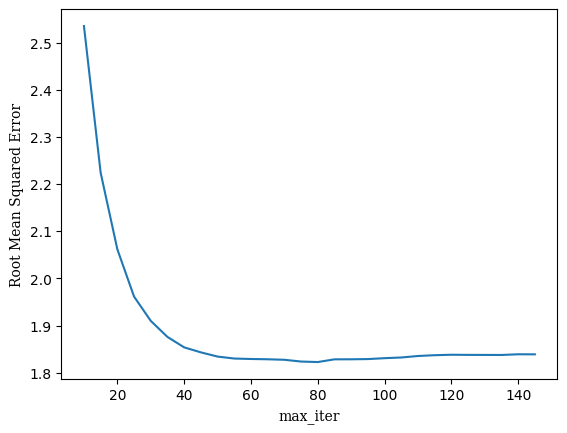

In [47]:
import matplotlib.pyplot as plt
# Plot the results of the grid search for the max_iter parameter vs the MSE
plt.plot(gsearch2.cv_results_['param_max_iter'], - gsearch2.cv_results_['mean_test_score'])
plt.xlabel('max_iter', fontfamily='serif')
plt.ylabel('Root Mean Squared Error', fontfamily='serif')

Vì số dòng dữ liệu không nhiều, nên mô hình không cần nhiều lần lặp để học. Ta thấy rằng với số lần lặp nhỏ hơn, độ chính xác của mô hình tăng lên.

In [48]:
gsearch2.cv_results_['mean_test_score']

array([-2.53536887, -2.22412781, -2.06169272, -1.96138651, -1.9098662 ,
       -1.87577201, -1.85365814, -1.84303534, -1.8341029 , -1.82993993,
       -1.82896622, -1.82836163, -1.82729253, -1.82355814, -1.82248311,
       -1.82823387, -1.82832739, -1.82877651, -1.83069523, -1.83217573,
       -1.83528575, -1.83701808, -1.83796786, -1.83768849, -1.83760743,
       -1.83749061, -1.83896899, -1.8388168 ])

In [49]:
gsearch2.best_params_

{'max_iter': 80}

In [50]:
hist_native_pipeline.max_iter = gsearch2.best_params_['max_iter']

### **Tối ưu các thông số ảnh hưởng đến cấu trúc cây**

Lưu ý rằng: thứ tự tùy chỉnh các thông số phải được sắp xếp theo mức độ ảnh hưởng đến mô hình.

**max_depth và min_samples_leaf**

Sau khi chỉ định learning_rate và max_iter, ta sẽ tối ưu các thông số ảnh hưởng đến cấu trúc của cây. Ban đầu, nhóm dùng GridSearchCV để tìm giá trị tối ưu cho max_depth trên khoảng từ 1-> 300 nhưng không tìm được giá trị tối ưu. Vì vậy, nhóm sẽ sử dụng cả 2 thông số max_depth và min_samples_leaf để tìm giá trị tối ưu cho mô hình.

In [17]:
from sklearn.model_selection import GridSearchCV

grid_param3 = {'max_depth' : range(1, 15, 2),
              'min_samples_leaf': range(10, 100, 10)}
gsearch3 = GridSearchCV(estimator = hist_native_pipeline, param_grid = grid_param3, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gsearch3.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(10, 100, 10)},
             scoring='neg_mean_squared_error')

In [58]:
gsearch3.cv_results_

{'mean_fit_time': array([0.09421778, 0.11817188, 0.09194651, 0.07625027, 0.06934028,
        0.06940513, 0.07034726, 0.07527146, 0.06785059, 0.14037552,
        0.13401384, 0.13975263, 0.17515678, 0.20705805, 0.19814835,
        0.16893635, 0.13402295, 0.143118  , 0.30456681, 0.30830431,
        0.29128413, 0.29911857, 0.35535612, 0.33249083, 0.32132964,
        0.39495773, 0.37371078, 0.54244189, 0.54610391, 0.55010729,
        0.57527261, 0.45664387, 0.41083012, 0.35292511, 0.35176568,
        0.38070526, 0.57975621, 0.52538757, 0.58808255, 0.51763301,
        0.56230431, 0.41123638, 0.62030678, 0.49006424, 0.55058341,
        0.5734333 , 0.49663229, 0.5044981 , 0.54120493, 0.58839259,
        0.69865365, 0.61996055, 0.51881442, 0.41545978, 0.48917894,
        0.46327648, 0.45562029, 0.50661459, 0.56532583, 0.60069518,
        0.72779527, 0.62256088, 0.41810665]),
 'std_fit_time': array([0.01082632, 0.02159901, 0.01092158, 0.00841472, 0.00928122,
        0.0035115 , 0.00666127, 0.007

In [30]:
gsearch3.best_params_

{'max_depth': 13, 'min_samples_leaf': 80}

Dựa vào max_depth = 13, ta sẽ tìm giá trị tối ưu cho min_samples_leaf bằng cách chia nhỏ khoảng giá trị.

In [64]:
grid_param4 = {'max_depth':[13],
              'min_samples_leaf': range(110, 150, 1)}
gsearch4 = GridSearchCV(estimator = hist_native_pipeline, param_grid = grid_param4, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gsearch4.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     learning_rate=0.075,
                                                     max_iter=80,
                                                     random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [13],
                         'min_samples_leaf': range(110, 150)},
             scoring='neg_mean_squared_error')

In [65]:
gsearch4.cv_results_

{'mean_fit_time': array([0.4200367 , 0.41010981, 0.42824764, 0.42804585, 0.4828589 ,
        0.40473943, 0.37695775, 0.35953989, 0.3350934 , 0.36569877,
        0.37748575, 0.365345  , 0.35790105, 0.34151802, 0.31824055,
        0.32167311, 0.31417975, 0.31941094, 0.31401486, 0.30389791,
        0.30863166, 0.30975976, 0.30486813, 0.30541291, 0.29887171,
        0.31282496, 0.30179682, 0.2977622 , 0.29305325, 0.28984108,
        0.29062099, 0.28988442, 0.28904896, 0.28119316, 0.28630586,
        0.29056363, 0.29017549, 0.29647403, 0.28099375, 0.24378767]),
 'std_fit_time': array([0.02057411, 0.02794745, 0.04434558, 0.03171547, 0.03872312,
        0.01486552, 0.0203557 , 0.01554383, 0.01556927, 0.0088911 ,
        0.00820286, 0.02665738, 0.02047289, 0.01666448, 0.00196761,
        0.00949107, 0.01369562, 0.00535821, 0.00517639, 0.00922622,
        0.00811043, 0.0151405 , 0.01451399, 0.00849637, 0.01203647,
        0.00995196, 0.00974581, 0.01337644, 0.00480395, 0.0089389 ,
        0.004

In [67]:
gsearch4.best_params_

{'max_depth': 13, 'min_samples_leaf': 116}

In [68]:
hist_native_pipeline.max_depth = gsearch4.best_params_['max_depth']
hist_native_pipeline.min_samples_leaf = gsearch4.best_params_['min_samples_leaf']

Kết quả khi chọn được max_depth = 13 và min_samples_leaf = 116 là MSE = 1.80646

**max_features**

In [82]:
grid_param5 = {'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}
gsearch5 = GridSearchCV(estimator = hist_native_pipeline, param_grid = grid_param5, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gsearch5.fit(X, y)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                     early_stopping=False,
                                                     learning_rate=0.075,
                                                     max_depth=13, max_iter=80,
                                                     min_samples_leaf=116,
                                                     random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [83]:
gsearch5.cv_results_

{'mean_fit_time': array([0.28629355, 0.38125238, 0.36228356, 0.32328963, 0.32323651,
        0.2832211 ]),
 'std_fit_time': array([0.03010068, 0.05002136, 0.0347141 , 0.02145832, 0.01844496,
        0.02514801]),
 'mean_score_time': array([0.02966418, 0.03094897, 0.03110614, 0.0306066 , 0.03436775,
        0.02575121]),
 'std_score_time': array([0.0051387 , 0.00536056, 0.00015302, 0.00561922, 0.00303996,
        0.00273606]),
 'param_max_features': masked_array(data=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'max_features': 0.1},
  {'max_features': 0.3},
  {'max_features': 0.5},
  {'max_features': 0.7},
  {'max_features': 0.9},
  {'max_features': 1.0}],
 'split0_test_score': array([-1.93688422, -1.92364836, -1.91079271, -1.90127993, -1.84673996,
        -1.87398218]),
 'split1_test_score': array([-1.76401495, -1.73256441, -1.72863244, -1.71871372, -1.74666775,
        -1.72280833]),
 'split2_tes

Vậy ta có các thông số tối ưu cho mô hình HistGradientBoostingRegressor:
- learning_rate = 0.075
- max_iter = 80
- max_depth = 13
- max_features = 1.0
- min_samples_leaf = 116

## **Kết quả**

Các biến giải thích được chọn bao gồm: 

In [23]:
selected_columns = ['area', 'district', 'bedroom', 'wc', 'numbers_of_floors', 'count_conveniences', 'has_rooftop', 'total_room_LLm', 'furnished', 'direction']


Các thông số được chọn bao gồm: 

In [18]:
best_params = {
    'learning_rate': 0.075,
    'max_iter': 80,
    'max_depth': 13,
    'min_samples_leaf': 116,
    'max_features': 1.0
}
hist_native_pipeline.set_params(**best_params)

HistGradientBoostingRegressor(categorical_features='from_dtype',
                              early_stopping=False, learning_rate=0.075,
                              max_depth=13, max_iter=80, min_samples_leaf=116,
                              random_state=42)

In [29]:
metrics = ['neg_mean_squared_error', 'r2']
scores = cross_validate(hist_native_pipeline, X, y, cv = 5, scoring = metrics)

mean_mse = -scores['test_neg_mean_squared_error'].mean()
sd_mse = scores['test_neg_mean_squared_error'].std()
mean_r2 = scores['test_r2'].mean()
sd_r2 = scores['test_r2'].std()
print("MSE:", scores['test_neg_mean_squared_error'])
print("R2:", scores['test_r2'])
print(tabulate([['MSE', mean_mse, sd_mse],['R2', mean_r2, sd_r2]], headers=['Metrics', 'Mean', 'SD'], tablefmt='orgtbl'))

MSE: [-1.86035349 -1.69965578 -1.49778715 -1.64089659 -2.2890743 ]
R2: [0.47723112 0.49049982 0.6144187  0.66139965 0.56625249]
| Metrics   |    Mean |        SD |
|-----------+---------+-----------|
| MSE       | 1.79755 | 0.271854  |
| R2        | 0.56196 | 0.0706316 |
